In [1]:
%matplotlib inline

# Quickstart
Section that runs through the API for common tasks.

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [3]:
# Download training data
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# Download test data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Next: pass the Datset as an argument to Dataloader, which wraps an iterable over hte dataset and supports automatic batching, sampling, shuffling, and mulitprocess data loading.  Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [4]:
batch_size = 64

# Create data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


## Creating Models
To define a neural network in PyTorch, we create a class that inherits from nn.Module.  The layers of the network are defined in the ``__init__`` function, and specify how data will pass through the network in the ``forward`` function.  To accelerate opterations in the neural network, we move it to the GPU if available.

In [5]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device.".format(device))

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)    

Using cpu device.
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


## Optimizing the Model Parameters
... make loss function, add optimizer

In [6]:
loss_fn = nn.CrossEntropyLoss()  # what's this one??
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)    # Stochastic Gradient Descent?

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model's parameters.

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

And setup test function as well

In [8]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= size
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Training conducted over iterations/epochs.  We train, then print accuracy/loss after each epoch to get an idea as to how the accuracy changes with training

In [9]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

Epoch 1
------------------
loss: 2.296291 [    0/60000]
loss: 2.293638 [ 6400/60000]
loss: 2.282891 [12800/60000]
loss: 2.283813 [19200/60000]
loss: 2.260386 [25600/60000]
loss: 2.243879 [32000/60000]
loss: 2.262010 [38400/60000]
loss: 2.239266 [44800/60000]
loss: 2.252949 [51200/60000]
loss: 2.219981 [57600/60000]
Test Error: 
 Accuracy: 34.6%, Avg loss: 0.034744 

Epoch 2
------------------
loss: 2.222712 [    0/60000]
loss: 2.215355 [ 6400/60000]
loss: 2.183740 [12800/60000]
loss: 2.210006 [19200/60000]
loss: 2.136893 [25600/60000]
loss: 2.103092 [32000/60000]
loss: 2.170690 [38400/60000]
loss: 2.100867 [44800/60000]
loss: 2.137300 [51200/60000]
loss: 2.102443 [57600/60000]
Test Error: 
 Accuracy: 39.8%, Avg loss: 0.032483 

Epoch 3
------------------
loss: 2.074734 [    0/60000]
loss: 2.052762 [ 6400/60000]
loss: 1.983814 [12800/60000]
loss: 2.081375 [19200/60000]
loss: 1.932110 [25600/60000]
loss: 1.877612 [32000/60000]
loss: 2.025376 [38400/60000]
loss: 1.889771 [44800/60000]
los

... that's impressively bad

## Saving Models
A common way to save a model is to serialize the internal state dictionary (basically pickle it?).  Makes sense though--the definition and the state is all that's needed

In [10]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Loading Models
Loading a model includes re-creating the structure and then loading the state dicitonary into it.

In [11]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [12]:
# and let's evaluate it!
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[2][0], test_data[2][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Dress", Actual: "Trouser"


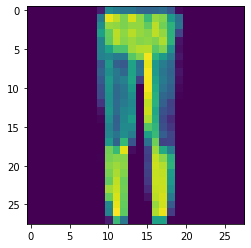

In [13]:
plt.imshow(test_data[3][0][0])

In [14]:
classes[test_data[2][1]]

'Trouser'